In [166]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [167]:
import pathlib

data_dir = pathlib.Path("DATA")

In [168]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

111

In [169]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['D46D', 'F35', 'L1', 'Triangle'], dtype='<U8')

In [170]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [171]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 115 images belonging to 4 classes.


In [172]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

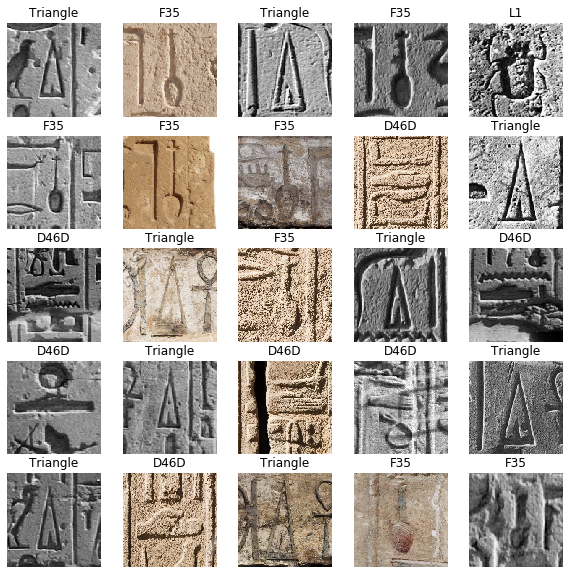

In [173]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [174]:
label = []
for item in label_batch:
    label.append(np.argmax(item))
label = np.array(label)

In [175]:
from sklearn.model_selection import train_test_split

(trainX, testX, trainY, testY) = train_test_split(image_batch, label, test_size=0.25)

In [176]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))

In [177]:
type(testY)

numpy.ndarray

In [178]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=12, 
                    validation_data=(testX, testY))

Train on 24 samples, validate on 8 samples
Epoch 1/12
24/24 [==============================] - 2s 74ms/sample - loss: 2.6185 - accuracy: 0.0000e+00 - val_loss: 4.3960 - val_accuracy: 0.1250
Epoch 2/12
24/24 [==============================] - 1s 54ms/sample - loss: 3.8796 - accuracy: 0.2500 - val_loss: 2.3633 - val_accuracy: 0.2500
Epoch 3/12
24/24 [==============================] - 1s 52ms/sample - loss: 3.5411 - accuracy: 0.5833 - val_loss: 1.4965 - val_accuracy: 0.3750
Epoch 4/12
24/24 [==============================] - 1s 49ms/sample - loss: 1.9110 - accuracy: 0.4583 - val_loss: 2.9898 - val_accuracy: 0.1250
Epoch 5/12
24/24 [==============================] - 1s 46ms/sample - loss: 2.4866 - accuracy: 0.2917 - val_loss: 2.1482 - val_accuracy: 0.1250
Epoch 6/12
24/24 [==============================] - 1s 46ms/sample - loss: 1.6710 - accuracy: 0.2917 - val_loss: 1.5462 - val_accuracy: 0.2500
Epoch 7/12
24/24 [==============================] - 1s 46ms/sample - loss: 1.1081 - accuracy: 0

8/1 - 0s - loss: 1.9352 - accuracy: 0.5000


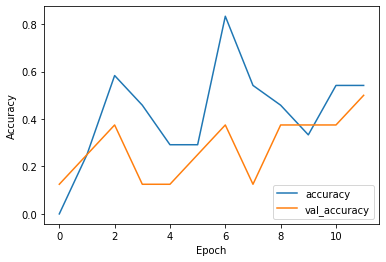

In [179]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(testX,  testY, verbose=2)

In [180]:
print(test_acc)

0.5
